In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import albumentations as A
import random
import json
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
import sys
from skimage import io
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision
import collections
from torchvision import datasets, models, transforms


In [ ]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
4# data_dir = '/content/drive/MyDrive/НТИ ИИ /data_team/'
project_dir = '/content/drive/MyDrive/НТИ ИИ /'
data_dir = 'data'
train_images = 'data/train_recognition/images'
image_size = 256
first_size = 512

# Settings

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection && pip install -e . && python setup.py develop

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html
     |████████████████████████████████| 46.0 MB 282 kB/s 
     |████████████████████████████████| 190 kB 28.3 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 23455, done.
remote: Total 23455 (delta 0), reused 0 (delta 0), pack-reused 23455
Receiving objects: 100% (23455/23455), 26.06 MiB | 16.31 MiB/s, done.
Resolving deltas: 100% (16384/16384), done.
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet
running develop
running egg_info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:381: UserWarning: Attempted to use ninja a

In [ ]:
!unzip -q '/content/drive/MyDrive/НТИ ИИ /data_team/data_final.zip'

In [ ]:
# !git clone https://bitbucket.org/william_rusnack/minimumboundingbox.git
# sys.path.append('minimumboundingbox')

In [ ]:
!pip install transformers -q
!pip install -q datasets jiwer
!pip install sentencepiece -q

     |████████████████████████████████| 3.8 MB 24.2 MB/s 
     |████████████████████████████████| 596 kB 60.5 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 58.5 MB/s 
     |████████████████████████████████| 6.5 MB 60.8 MB/s 
     |████████████████████████████████| 311 kB 17.6 MB/s 
     |████████████████████████████████| 134 kB 62.4 MB/s 
     |████████████████████████████████| 1.1 MB 244 kB/s 
     |████████████████████████████████| 212 kB 50.7 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 144 kB 14.7 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 271 kB 56.9 MB/s 
     |████████████████████████████████| 1.2 MB 13.5 MB/s 


# Building datasets

In [ ]:
annotation = pd.read_csv('data/train_recognition/labels.csv')
annotation.head(10)

,file_name,text,base_image
0,0.png,"дверку,",1_5.JPG
1,1.png,открыл,1_5.JPG
2,2.png,Я,1_5.JPG
3,3.png,хвостом.,1_5.JPG
4,4.png,вилял,1_5.JPG
5,5.png,и,1_5.JPG
6,6.png,рядом,1_5.JPG
7,7.png,крутился,1_5.JPG
8,8.png,Рыжик,1_5.JPG
9,9.png,вареньем.,1_5.JPG


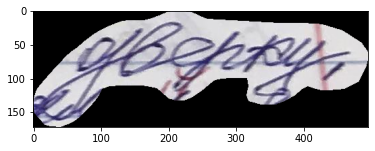

In [ ]:
image = plt.imread(os.path.join(train_images, '0.png'))
plt.imshow(image)
plt.show()

In [ ]:
len(os.listdir(train_images))

161700

In [ ]:
import json

with open(data_dir+'/train_segmentation/annotations.json') as f:
    seg_annotations = json.load(f)

In [ ]:
from sklearn.model_selection import train_test_split

val_annot = seg_annotations.copy()
train_annot = seg_annotations.copy()

train_annot['images'], val_annot['images']  = train_test_split(seg_annotations['images'], test_size=0.1, random_state=42)

In [ ]:
with open(os.path.join(data_dir, 'train_segmentation/annotations_val.json'), 'w') as outfile:
    json.dump(val_annot, outfile)
    
    
with open(os.path.join(data_dir, 'train_segmentation/annotations_train.json'), 'w') as outfile:
    json.dump(train_annot, outfile)

# Get masks

In [ ]:
sys.path.append('mmdetection')

import mmdet
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import init_detector, inference_detector, show_result_pyplot, set_random_seed

In [ ]:
def get_contours_from_mask(mask, min_area=100):
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8),
                                           cv2.RETR_LIST,
                                           cv2.CHAIN_APPROX_SIMPLE
                                           )
    contour_list = []
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            contour_list.append(contour)
    return contour_list

In [ ]:
import mask_creation

class SEGMpredictor:
    def __init__(self, model_path):
         self.model = torch.load(model_path, map_location=device)
         self.model = self.model.eval()
    
    def __call__(self, image, return_mask=False):
        image = image.copy()
        mask = mask_creation.predict_full_img(image, self.model, device)
        mask_post = mask != 0
        
        # mask_post = mask_postprocessing(image, mask_post)
        ans = get_contours_from_mask(mask_post)

        if return_mask:
          return mask, ans
        
        return ans

In [ ]:
import importlib
importlib.reload(mask_creation)
mask_creation.NUMBER_WORKERS = 2
mask_creation.BATCH_SIZE = 8
mask_creation.SHIFT = 60

In [ ]:
model = torch.load('/content/drive/MyDrive/НТИ ИИ /team/sergey_models/mask_rcnn_small')

In [ ]:
image = cv2.imread('data/train_segmentation/images/0_0_eng.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
image = image[::2, ::2]

In [ ]:
%%time
pred = mask_creation.predict_full_img(image, model, device)

CPU times: user 2.06 s, sys: 15.8 ms, total: 2.08 s
Wall time: 2.06 s


In [ ]:
import collections
collections.Counter(pred.flatten()).most_common()[:10]
len(collections.Counter(pred.flatten()).most_common())

294

In [ ]:
shuffled = np.zeros_like(pred)
for i, c in enumerate(random.sample(np.unique(pred).tolist(), len(np.unique(pred)))):
  if c != 0:
    shuffled[pred == c] = i + 1

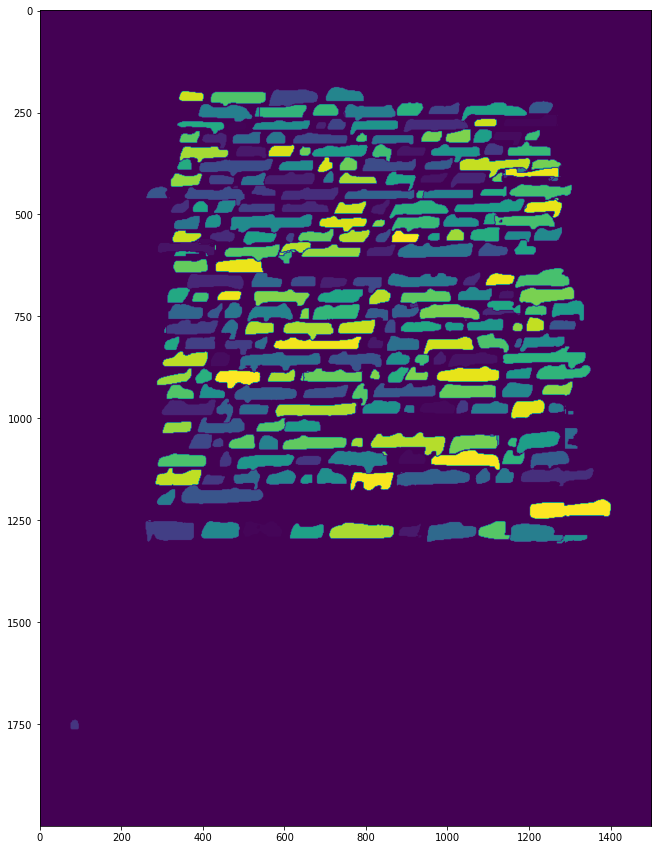

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(shuffled)
plt.show()

In [ ]:
shuffled = np.zeros_like(image)
for i, c in enumerate(random.sample(np.unique(pred).tolist(), len(np.unique(pred)))):
  if c != 0:
    shuffled[pred == c] = np.random.randint(0, 255, size=(3))

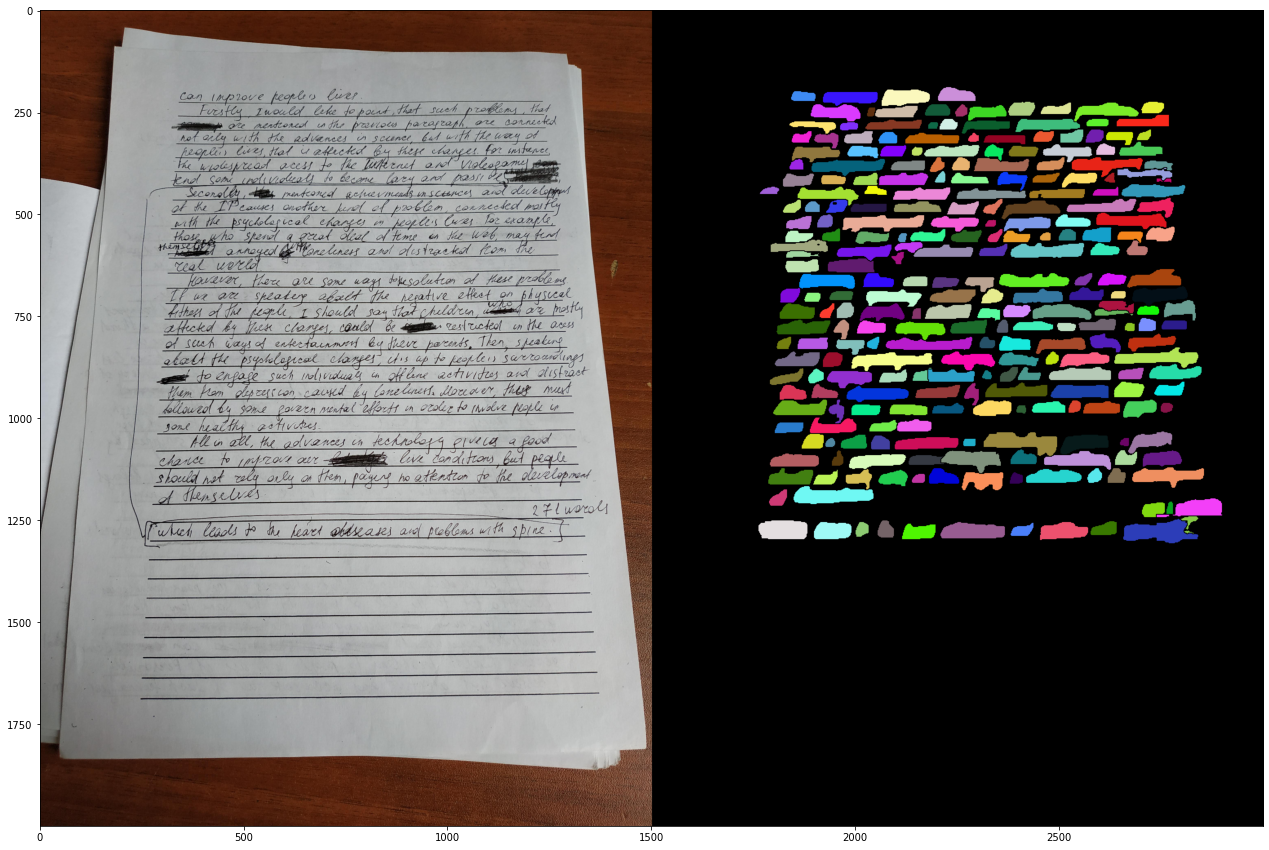

In [ ]:
plt.figure(figsize=(30,15))
plt.imshow(np.concatenate([image, shuffled], axis=1))
plt.show()

# Loading TrOcr

In [ ]:
def plot_images(images_for_show):
  """Строит изображение на одном графике"""
  fig = plt.figure(figsize=(16, 16))

  columns = len(images_for_show)
  rows = 1
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.clip(images_for_show[i - 1], 0, 1))
    
  fig.subplots_adjust(wspace=0.1, hspace=0)
  plt.show()

In [ ]:
class AlbuPadding(A.DualTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(AlbuPadding, self).__init__(always_apply, p)

    def apply(self, image, **params):
        zeros = np.zeros((128, 384, 3))
        image = np.concatenate([zeros, image, zeros], axis=0)
        return image.astype(np.uint8)

In [ ]:
from albumentations.pytorch.transforms import ToTensor
from transformers import AutoFeatureExtractor, XLMRobertaTokenizer, VisionEncoderDecoderModel, RobertaTokenizer

class TrOcrModel:
  def __init__(self, model_path, padding=True):
      self.model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)
      self.model.eval()

      self.feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/trocr-small-handwritten')
      self.tokenizer = XLMRobertaTokenizer.from_pretrained('microsoft/trocr-small-handwritten')
      
      if padding:
        self.transforms = A.Compose([
                A.Resize(128, 384),
                AlbuPadding(always_apply=True),
            ])
      else:
        self.transforms = A.Compose([
                A.Resize(384, 384),
            ])
  
  def image_preprocess(self, image):
      image = self.transforms(image=image)['image']
      pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
      return pixel_values

  def predict_batch(self, images):
      batch = torch.concat([self.image_preprocess(image) for image in images], axis=0).to(device)
      outputs = self.model.generate(batch)
      return [self.tokenizer.decode(pred.cpu().numpy(), skip_special_tokens=True) for pred in outputs]

  def __call__(self, image):
      pred = self.model.generate(self.image_preprocess(image).to(device))
      return self.tokenizer.decode(pred[0].cpu().numpy(), skip_special_tokens=True)   

In [ ]:
text_model = TrOcrModel("/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_small_aug_nti2data")

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/238 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

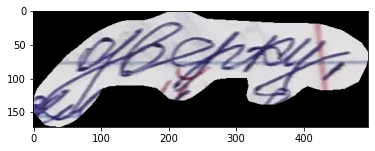

In [ ]:
image = cv2.imread(os.path.join(train_images, '0.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
text_model(image)

'дверку,'

In [ ]:
text_model.predict_batch([image, image])

['дверку,', 'дверку,']

# Making predict

In [ ]:
from PIL import ImageFont, ImageDraw, Image

In [ ]:
def crop_img_by_polygon(img, polygon):
    # https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w]
    pts = pts - pts.min(axis=0)
    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    return dst

In [ ]:
def get_image_visualization(img, pred_data, fontpath, font_koef=50):
    img = img.copy()
    h, w = img.shape[:2]
    font = ImageFont.truetype(fontpath, int(h/font_koef))
    empty_img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(empty_img)

    for prediction in pred_data['predictions']:
        polygon = prediction['polygon']
        pred_text = prediction['text']
        cv2.drawContours(img, np.array([polygon]), -1, (0, 255, 0), 2)
        x, y, w, h = cv2.boundingRect(np.array([polygon]))
        draw.text((x, y), pred_text, fill=0, font=font)
        # print(pred_text, x, y)

    vis_img = np.array(empty_img)
    vis = np.concatenate((img, vis_img), axis=1)
    return vis

In [ ]:
def get_polygon_for_answer(polygon, croped):
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x1,y1,w,h = rect
    mid_x = x1 + w // 2
    mid_y = y1 + h // 2

    best = 1e9
    for i in range(h):
      now = abs((croped[:i, :] != [0, 0, 0]).sum() - (croped[i:, :] != [0, 0, 0]).sum())
      if now < best:
        best = now
        mid_y = i + y1

    x1 = mid_x - w // 5
    x2 = mid_x + w // 5
    # return [(mid_y, x1), (mid_y + 5, x1), (mid_y + 5, x2), (mid_y, x2)]
    return [(x1, mid_y), (x1, mid_y + 1), (x2, mid_y + 1), (x2, mid_y)]

In [ ]:
def get_classifier_model():

  model = models.resnet50(pretrained=True)
  model.fc = nn.Sequential(
      nn.Linear(2048, 256),
      nn.ReLU(),
      nn.Linear(256, 2)
  )
  return model

In [ ]:
with open(os.path.join(data_dir, 'train_segmentation/annotations.json'), 'r') as f:
    annotations = json.load(f)

def get_image_cer(image_name):
  img = cv2.imread('data/train_segmentation/images/' + image_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pred_data = {}
  pred_data[image_name] = pipeline_model(img)
  with open('prediction.json', "w") as f:
    json.dump(pred_data, f)

  now = annotations.copy()
  for el in annotations['images']:
    if el['file_name'] == image_name:
      now['images'] = [el]
      break

  
  with open(os.path.join('annotations_now.json'), 'w') as outfile:
      json.dump(now, outfile)
  print('predict is ready')
  
  print(os.popen('python3 data/evaluate.py --ref_path annotations_now.json --pred_path prediction.json').read())

In [ ]:
import re

class PiepleinePredictor:
    def __init__(self, segm_model_path, ru_ocr_model_path, en_ocr_model_path, classifier_model_path, multilingual_model_path):
        self.seg_model = SEGMpredictor(segm_model_path)
        self.text_model = {'ru': TrOcrModel(ru_ocr_model_path),
                           'en': TrOcrModel(en_ocr_model_path, False),
                           'multiling': TrOcrModel(multilingual_model_path, False)}
        self.batch_size = 8
        self.transforms = A.RandomScale(scale_limit=(-0.5, -0.5), p=1)

        self.classifier_model = torch.load(classifier_model_path, map_location=device)
        self.classifier_predicts = 5
        self.classifier_transforms = A.Compose([
                  A.Resize(128, 384),
                  ToTensor()
              ])

    def predict_language(self, images):
        p = np.argsort([el.shape[1] for el in images])
        batch = []
        for idx in p[-self.classifier_predicts:]:
          batch.append(images[idx])

        preds = self.text_model['multiling'].predict_batch(batch)
        # print(preds)
        ru = [len(re.findall('[а-яА-Я]', el)) > len(re.findall('[a-zA-Z]', el)) for el in preds]
        
        res = np.sum(ru) > len(preds) / 2
        return 'ru' if res else 'en'

    def __call__(self, img, return_only_language=False):
        img = img.copy()
        img = self.transforms(image=img)['image']
        with torch.no_grad():
          output = {'predictions': []}
          contours = self.seg_model(img)
          images = []
          not_none_contours = []
          for contour in contours:
              if contour is not None:
                  crop = crop_img_by_polygon(img, contour)
                  images.append(crop)
                  not_none_contours.append(contour)

          language = self.predict_language(images)
          if return_only_language:
            return language

          predicted_text = []
          for i in range(0, len(images), self.batch_size):
            predicted_text += self.text_model[language].predict_batch(images[i:i + self.batch_size])

          for pred_text, contour in zip(predicted_text, not_none_contours):
            output['predictions'].append({
                              'polygon': [[int(i[0][0] * 2), int(i[0][1] * 2)] for i in contour],
                              # 'polygon': get_polygon_for_answer(contour, crop),
                              'text': pred_text
                            })
        return output

In [ ]:
pipeline_model = PiepleinePredictor(
                                    # '/content/drive/MyDrive/НТИ ИИ /team/semeka_models/after_mask_rcnn_small_en_last_9',
                                    '/content/drive/MyDrive/НТИ ИИ /team/sergey_models/mask_rcnn_small_adam_en_best',
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_small",
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_eng",
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/language_classifier",
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_multilingual",
                                    ) #_aug_nti2data

In [ ]:
importlib.reload(mask_creation)

<module 'mask_creation' from '/content/mask_creation.py'>

In [ ]:
get_image_cer('0_0_eng.jpg') # only scores=0.5

predict is ready
{'CER': 0.1669278996865204}



In [ ]:
path = 'data/train_segmentation/images'

sum = 0
right = 0
for image_name in tqdm(os.listdir(path)[300:]):
  real = 'en' if 'eng' in image_name else 'ru'
  img = cv2.imread(os.path.join(path, image_name))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pred = pipeline_model(img, True)
  sum += 1
  right += pred == real
  if pred != real:
    print(image_name, real)

print()
print(right, sum)

100%|██████████| 632/632 [22:34<00:00,  2.14s/it]


632 632


In [ ]:
img = cv2.imread('data/train_segmentation/images/105_0.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

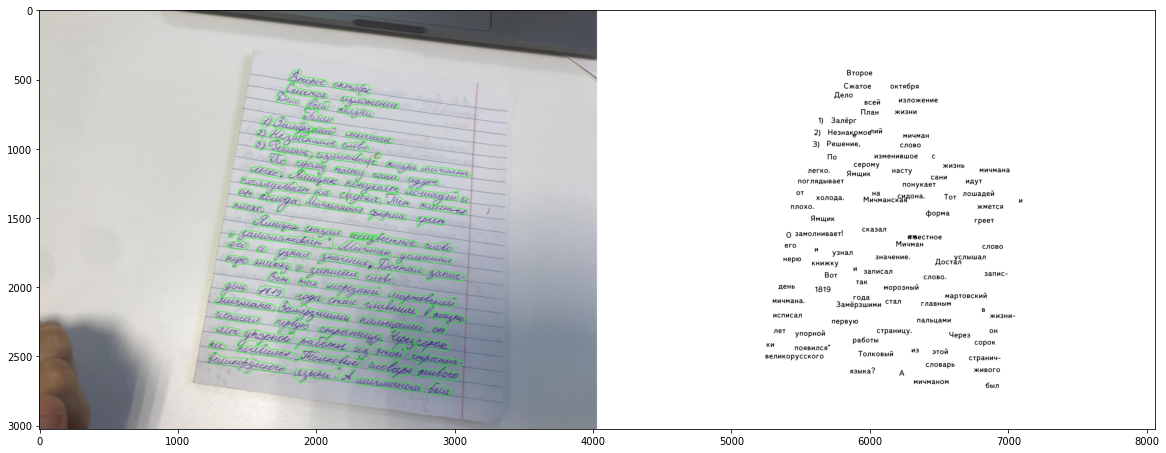

In [ ]:
output = pipeline_model(img)
vis = get_image_visualization(img, output, os.path.join(data_dir, 'font.otf'))

plt.figure(figsize=(20, 20))
plt.imshow(vis)
plt.show()

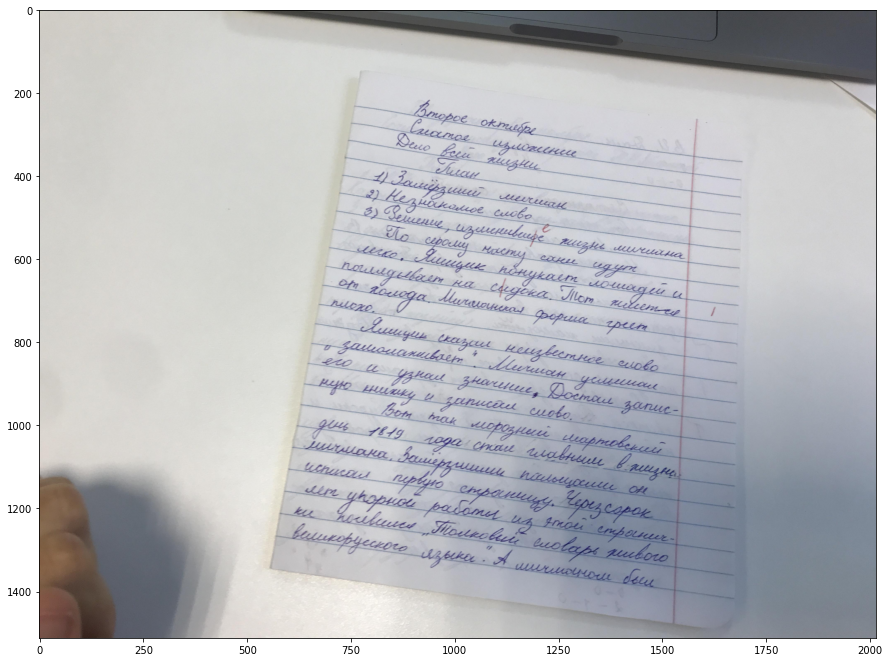

In [ ]:
img = cv2.imread('data/train_segmentation/images/105_0.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = A.RandomScale(scale_limit=(-0.5, -0.5), p=1)(image=img)['image']

plt.figure(figsize=(15, 15))
plt.imshow(img)

# Save predictions from dataset

In [ ]:
# Путь к json'у с разметкой
DATA_JSON_PATH = 'data/train_segmentation/annotations_val.json'

# Папка с картинками тетрадей
IMAGE_ROOT = 'data/train_segmentation/images/'

# Файл для сохранения предсказаний пайплайна. Один json
SAVE_PATH = os.path.join(project_dir, 'prediction.json')

In [ ]:
with open(DATA_JSON_PATH, 'r') as f:
    data = json.load(f)

pred_data = {}

In [ ]:
for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pred_data[img_name] = pipeline_model(image)

100%|██████████| 94/94 [13:57<00:00,  8.91s/it]


In [ ]:
for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pred_data[img_name] = pipeline_model(image)

100%|██████████| 94/94 [18:50<00:00, 12.03s/it]


In [ ]:
with open('prediction.json', "w") as f:
    json.dump(pred_data, f)

In [ ]:
#small
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.1509543789153041}


In [ ]:
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.17972025929758892}


In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier not regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.1522985675333629}


In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.27107049797544236}


In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier not regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.1522985675333629}


In [ ]:
# mask_rcnn_small + en_ocr + classifier not regression (25) + scores
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.12143361309079996}


In [ ]:
# mask_rcnn_small + en_ocr + classifier not regression (25) + scores + p=0.7
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.12724393794998187}


In [ ]:
# mask_rcnn_small + en_ocr + classifier not regression (25) + scores + leave biggest + p=0.5
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.13439109954251288}


In [ ]:
# mask_rcnn_small + en_ocr + classifier ocr + upsize + scores
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.12174061089610466}


In [ ]:
# semeka_models/mask_rcnn_small_en_last_46 + en_ocr + classifier ocr + scores
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.1533351948157141}


In [ ]:
# semeka_models/after_mask_rcnn_small_en_last_9 + en_ocr + classifier ocr + scores
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.14850834884877498}


In [ ]:
# mask_rcnn_small_en_last + en_ocr + classifier ocr + scores
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.1461818296235262}


In [ ]:
# mask_rcnn_small_adam_en_best
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

{'CER': 0.13198224534459863}
